### North-South photometry

The purpose of this notebook is to explore the differences in the observed and synthesized photometry in the overlap region between the (north) BASS+MzLS and (south) DECaLS photometric catalogs.

For details, see:
https://data.desi.lbl.gov/desi/users/ioannis/fastspecfit/northsouth/README.txt.

**Note: all photometric fluxes have been corrected for Galactic extinction.**

John Moustakas  
Siena College  
April 2024

In [1]:
import os
import numpy as np
import fitsio
from glob import glob
import corner as cn
from astropy.table import Table, join

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='talk', style='whitegrid', font_scale=0.7)
colors = sns.color_palette()

%matplotlib inline

In [3]:
projectdir = '/global/cfs/cdirs/desicollab/users/ioannis/fastspecfit/northsouth'

### Motivating results

The DESI Durham group has reported a (small) systematic difference in the distribution of rest-frame $g-r$ colors between galaxies with BASS+MzLS vs DECaLS photometry based on the `FastSpecFit` `Iron/v2.1` value-added catalog for `main/bright` (BGS) targets, as shown in the [following slides](https://docs.google.com/presentation/d/1RWmCTnj1Uss_bf2py-qBQlL_zm8jaQsQoeyddUTgyzc/edit#slide=id.g2c49471da5f_0_0).

Reproduce that result here.

In [4]:
fastfile = '/global/cfs/cdirs/desi/public/dr1/vac/dr1/fastspecfit/iron/v2.1/catalogs/fastspec-iron-main-bright.fits'

In [5]:
cols = ['SURVEY', 'PROGRAM', 'HEALPIX', 'TARGETID', 'RA', 'DEC', 'PHOTSYS', 'FLUX_G', 'FLUX_R', 'FLUX_Z']
%time vacmeta = Table(fitsio.read(fastfile, 'METADATA', columns=cols))

CPU times: user 3.89 s, sys: 1.86 s, total: 5.75 s
Wall time: 5.92 s


In [6]:
cols = ['ABSMAG01_SDSS_G', 'ABSMAG01_IVAR_SDSS_G', 'ABSMAG01_SDSS_R', 'ABSMAG01_IVAR_SDSS_R']
%time vacfast = Table(fitsio.read(fastfile, 'FASTSPEC', columns=cols))

CPU times: user 3.51 s, sys: 16.5 s, total: 20 s
Wall time: 1min 22s


In [7]:
I = (vacfast['ABSMAG01_IVAR_SDSS_G'] > 0) * (vacfast['ABSMAG01_IVAR_SDSS_R'] > 0)
N = I * (vacmeta['PHOTSYS'] == 'N')
S = I * (vacmeta['PHOTSYS'] == 'S')

In [8]:
abslim = [-12, -28]
grlim = [0., 1.2]

The figure below shows the very small ($\sim0.01$ mag) shift in the mean location of the red sequence for objects with DECaLS photometry vs those with BASS+MzLS photometry.

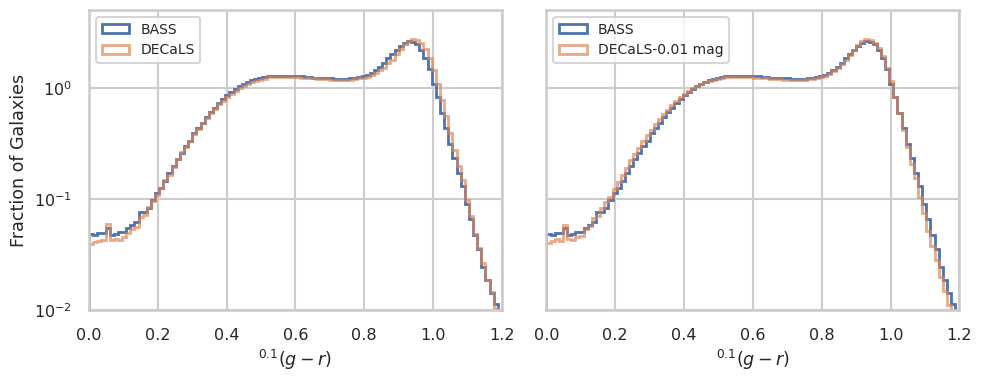

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

_ = ax1.hist(vacfast['ABSMAG01_SDSS_G'][N]-vacfast['ABSMAG01_SDSS_R'][N], 
             bins=100, log=True, histtype='step', range=grlim,
             density=True, label='BASS', lw=2)
_ = ax1.hist(vacfast['ABSMAG01_SDSS_G'][S]-vacfast['ABSMAG01_SDSS_R'][S], 
             bins=100, log=True, histtype='step', range=grlim,
             density=True, label='DECaLS', lw=2, alpha=0.7)
ax1.set_ylabel('Fraction of Galaxies')
ax1.legend(loc='upper left', fontsize=10)

_ = ax2.hist(vacfast['ABSMAG01_SDSS_G'][N]-vacfast['ABSMAG01_SDSS_R'][N], 
             bins=100, log=True, histtype='step', range=grlim,
             density=True, label='BASS', lw=2)
_ = ax2.hist(vacfast['ABSMAG01_SDSS_G'][S]-vacfast['ABSMAG01_SDSS_R'][S]-0.01, 
             bins=100, log=True, histtype='step', range=grlim,
             density=True, label='DECaLS-0.01 mag', lw=2, alpha=0.7)
ax2.legend(loc='upper left', fontsize=10)

for xx in (ax1, ax2):
    xx.set_xlim(grlim)
    xx.set_ylim(1e-2, 5.)
    xx.set_xlabel(r'$^{0.1}(g-r)$')
    
fig.tight_layout()

Examining the individual $g$- and $r$-band luminosity functions, we see a more pronounced difference in the two photometric datasets for bright objects, $-23\gtrsim M_{0.1g} \gtrsim -26$ and $-24\gtrsim M_{0.1r} \gtrsim -26$.

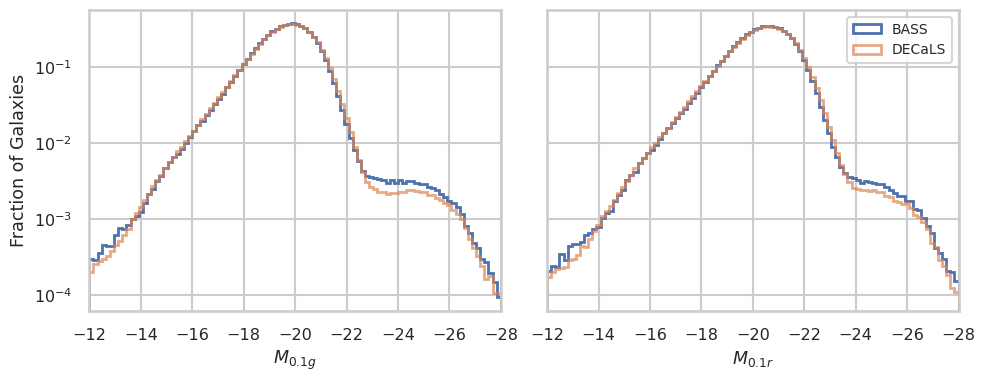

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
_ = ax1.hist(vacfast['ABSMAG01_SDSS_G'][N], bins=100, log=True, 
             histtype='step', range=abslim[::-1], density=True, 
             label='BASS', lw=2)
_ = ax1.hist(vacfast['ABSMAG01_SDSS_G'][S], bins=100, log=True, 
             histtype='step', range=abslim[::-1], density=True, 
             label='DECaLS', lw=2, alpha=0.7)
ax1.set_xlim(abslim)
ax1.set_xlabel(r'$M_{0.1g}$')
ax1.set_ylabel('Fraction of Galaxies')

_ = ax2.hist(vacfast['ABSMAG01_SDSS_R'][N], bins=100, log=True, 
             histtype='step', range=abslim[::-1], density=True, 
             label='BASS', lw=2)
_ = ax2.hist(vacfast['ABSMAG01_SDSS_R'][S], bins=100, log=True, 
             histtype='step', range=abslim[::-1], density=True, 
             label='DECaLS', lw=2, alpha=0.7)
ax2.set_xlim(abslim)
ax2.set_xlabel(r'$M_{0.1r}$')
ax2.legend(loc='upper right', fontsize=10)

fig.tight_layout()

To get to the bottom of these discrepancies, let's compare the rest-frame photometry of objects with both BASS+MzLS and DECaLS fluxes, keeping everything else the same.

### Read the parent sample

The figure below shows how we select the subset of objects in the overlap regions (as defined in Dey+2019, Table 2).

In [11]:
def read_parent():
    metafile = os.path.join(projectdir, 'metadata-iron-main-bright.fits')
    northfile = os.path.join(projectdir, 'tractor-iron-main-bright-north.fits')
    southfile = os.path.join(projectdir, 'tractor-iron-main-bright-south.fits')
    meta = Table(fitsio.read(metafile))
    north = Table(fitsio.read(northfile))
    south = Table(fitsio.read(southfile))
        
    return meta, north, south

In [12]:
%time parent_meta, tractor_north, tractor_south = read_parent()

CPU times: user 1.02 s, sys: 911 ms, total: 1.93 s
Wall time: 2.2 s


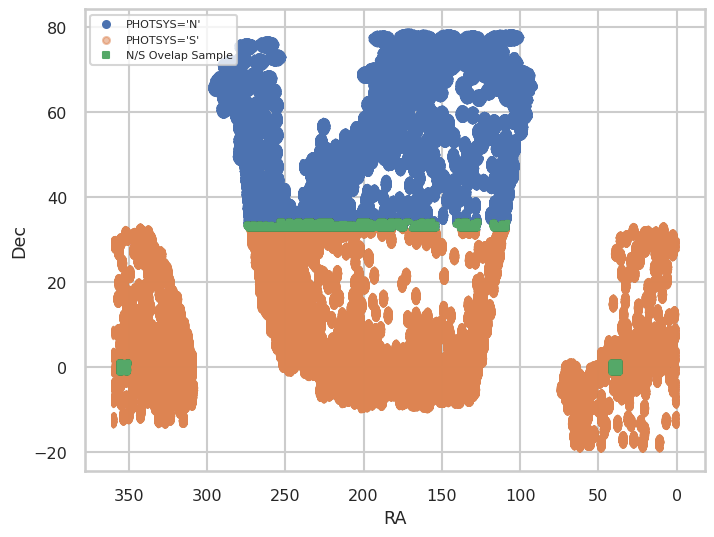

In [13]:
I = (vacmeta['FLUX_G'] > 0) * (vacmeta['FLUX_R'] > 0) * (vacmeta['FLUX_Z'] > 0)
N = I * (vacmeta['PHOTSYS'] == 'N')
S = I * (vacmeta['PHOTSYS'] == 'S')

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(vacmeta['RA'][N], vacmeta['DEC'][N], s=1, label="PHOTSYS='N'")
ax.scatter(vacmeta['RA'][S], vacmeta['DEC'][S], s=1, alpha=0.5, label="PHOTSYS='S'")
ax.scatter(parent_meta['RA'], parent_meta['DEC'], s=1, marker='s', label='N/S Ovelap Sample')
ax.invert_xaxis()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.legend(loc='upper left', fontsize=8, markerscale=5);

### Read the fitting results

Here, we have modeled the same set of $\approx10^{5}$ objects using `fastphot` (neglecting the DESI spectrophotometry) and only changing the input photometry.

In [14]:
def read_fastphot():
    northfile = os.path.join(projectdir, 'north', 'iron', 'catalogs', 'fastphot-iron-north.fits')
    southfile = os.path.join(projectdir, 'south', 'iron', 'catalogs', 'fastphot-iron-south.fits')
    fastnorth = Table(fitsio.read(northfile, 'FASTPHOT'))
    fastsouth = Table(fitsio.read(southfile, 'FASTPHOT'))
    metanorth = Table(fitsio.read(northfile, 'METADATA'))
    metasouth = Table(fitsio.read(southfile, 'METADATA'))
        
    return fastnorth, fastsouth, metanorth, metasouth

In [15]:
%time fastnorth, fastsouth, metanorth, metasouth = read_fastphot()

CPU times: user 371 ms, sys: 303 ms, total: 674 ms
Wall time: 1.05 s


In [16]:
assert(np.all(metanorth['TARGETID'] == metasouth['TARGETID']))

### Analysis

**Note: in all the residual plots, below, the statistics listed are the median and mean+/-stddev of the residuals.**

In [17]:
glim = (17, 22.5)
rlim = (16, 21)
gabslim = (-15, -24)
rabslim = (-15, -24)
residlim = (-2, 2)
residlim2 = (-1, 1)

In [18]:
def cplot(x, y, lim, residlim, xlabel, ylabel, residlabel, band=None, 
          ccol=colors[1], levels=[0.5, 0.75, 0.95, 0.99], smooth=1.5, 
          isflux=True):
    
    # convert to mag
    if isflux:
        x = 22.5 -2.5 * np.log10(x)
        y = 22.5 -2.5 * np.log10(y)
    
    contour_kwargs = {'colors': 'k', 'alpha': 0.8, 'linewidths': 1}
    data_kwargs = {'color': ccol, 'alpha': 0.5, 'ms': 2}

    fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True, gridspec_kw={'height_ratios': [1, 0.4]})
    _ = cn.hist2d(x, y, range=[lim, lim], bins=100, color=ccol, 
                  smooth=smooth, levels=levels, contour_kwargs=contour_kwargs,
                  data_kwargs=data_kwargs, ax=ax[0])
    ax[0].plot(lim, lim, color='k', alpha=0.7)
    #ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
        
    _ = cn.hist2d(x, y-x, range=[lim, residlim], bins=100, color=ccol, 
                  smooth=smooth, levels=levels, contour_kwargs=contour_kwargs,
                  data_kwargs=data_kwargs, ax=ax[1])
    ax[1].axhline(y=0, color='k')
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel(residlabel, alpha=0.7)

    stats = r'$\Delta$='+f'{np.median(y-x):.4f}'+f' ({np.mean(y-x):.4f}'+r'$\pm$'+f'{np.std(y-x):.4f})'    
    ax[1].text(0.03, 0.85, stats, va='center', ha='left', 
               transform=ax[1].transAxes, fontsize=12)
    
    fig.tight_layout()

#### Compare *g* [BASS] vs $g$ [DECaLS] and *r* [BASS] vs $r$ [DECaLS] from Tractor.

Findings: 
* $g$ [BASS, Tractor] is approximately 0.05-0.06 mag fainter than [DECaLS, Tractor]
* $r$ [BASS, Tractor] is approximately 0.02 mag fainter than [DECaLS, Tractor]

Note that these results are not unexpected given the different filter functions and photometric systems.

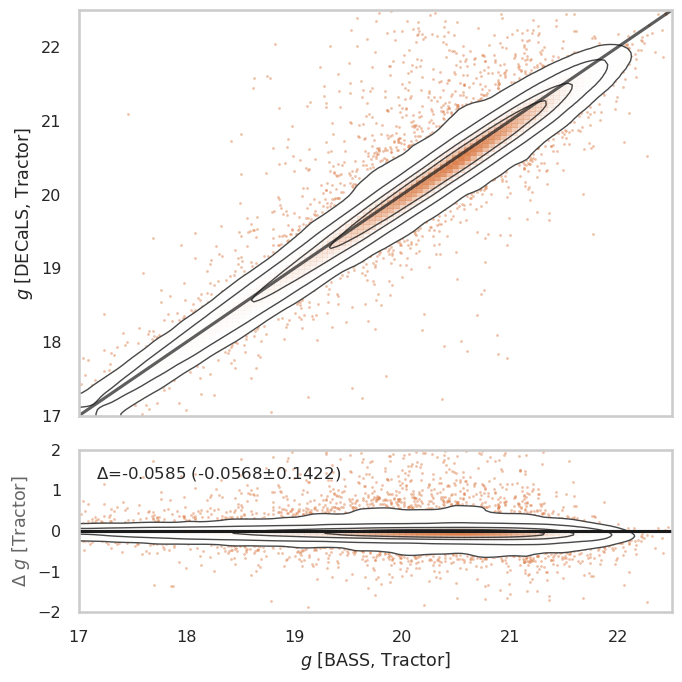

In [19]:
cplot(metanorth['FLUX_G'], metasouth['FLUX_G'], glim, residlim, 
      r'$g$ [BASS, Tractor]', r'$g$ [DECaLS, Tractor]', r'$\Delta\ g$ [Tractor]', 
      isflux=True)

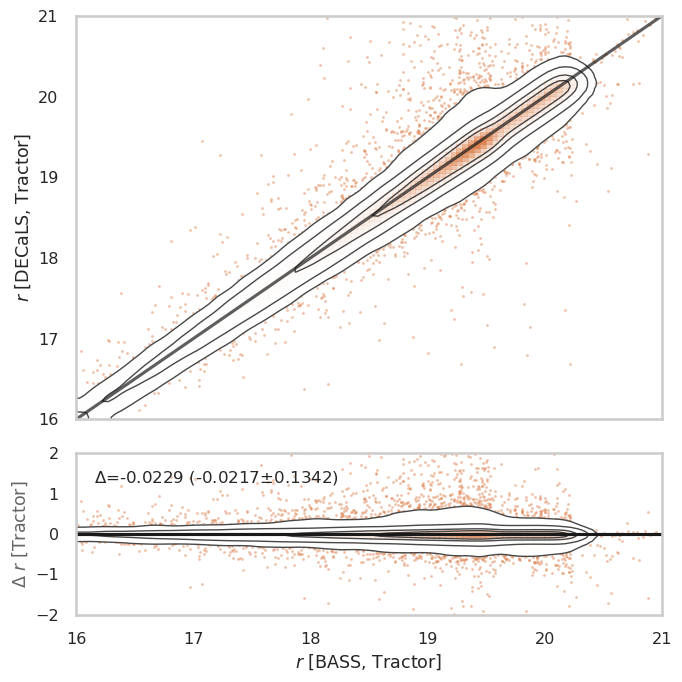

In [20]:
cplot(metanorth['FLUX_R'], metasouth['FLUX_R'], rlim, residlim, 
      r'$r$ [BASS, Tractor]', r'$r$ [DECaLS, Tractor]', r'$\Delta\ r$ [Tractor]', 
      isflux=True)

#### Compare Tractor (observed) and `fastphot` (synthesized) photometry.

Findings: 
* $g$ [BASS, Tractor] and $g$ [BASS, fastphot] agree to better than $\ll0.01$ mag.
* $r$ [BASS, Tractor] and $r$ [BASS, fastphot] agree to better than $\ll0.01$ mag.
* $g$ [DECaLS, Tractor] and $g$ [DECaLS, fastphot] agree to better than $\ll0.01$ mag.
* $r$ [DECaLS, Tractor] and $r$ [DECaLS, fastphot] agree to better than $\ll0.01$ mag.

Conclusions:
* The `fastphot` models are a very good description of the data.

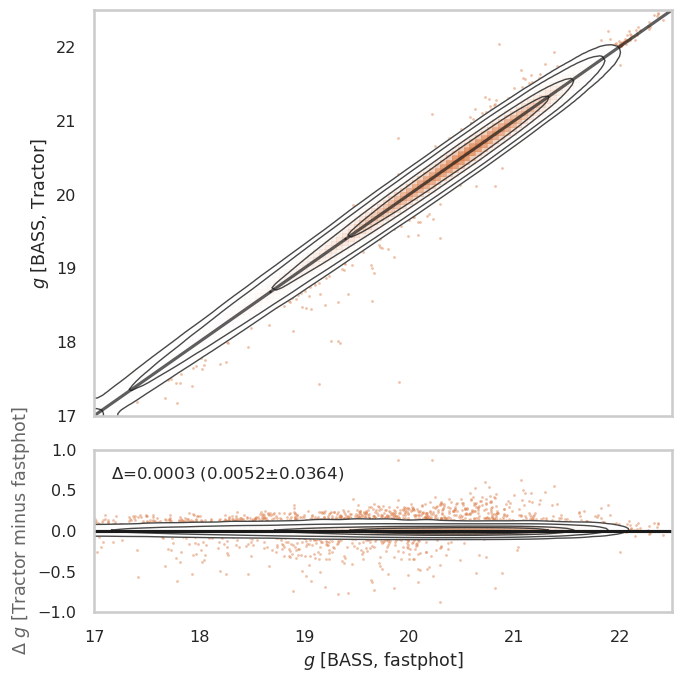

In [21]:
cplot(fastnorth['FLUX_SYNTH_PHOTMODEL_G'], metanorth['FLUX_G'], glim, residlim2, 
      r'$g$ [BASS, fastphot]', r'$g$ [BASS, Tractor]', r'$\Delta\ g$ [Tractor minus fastphot]', isflux=True)

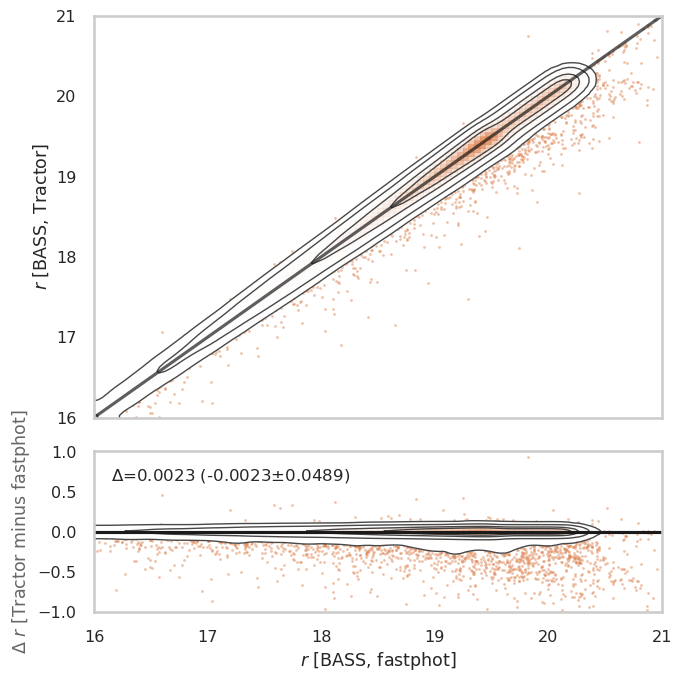

In [22]:
cplot(fastnorth['FLUX_SYNTH_PHOTMODEL_R'], metanorth['FLUX_R'], rlim, residlim2, 
      r'$r$ [BASS, fastphot]', r'$r$ [BASS, Tractor]', r'$\Delta\ r$ [Tractor minus fastphot]', isflux=True)

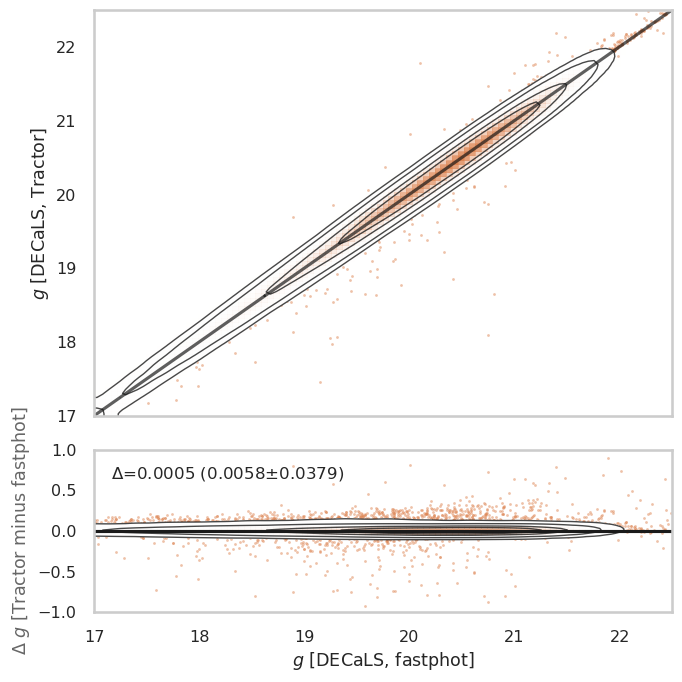

In [23]:
cplot(fastsouth['FLUX_SYNTH_PHOTMODEL_G'], metasouth['FLUX_G'], glim, residlim2, 
      r'$g$ [DECaLS, fastphot]', r'$g$ [DECaLS, Tractor]', r'$\Delta\ g$ [Tractor minus fastphot]', isflux=True)

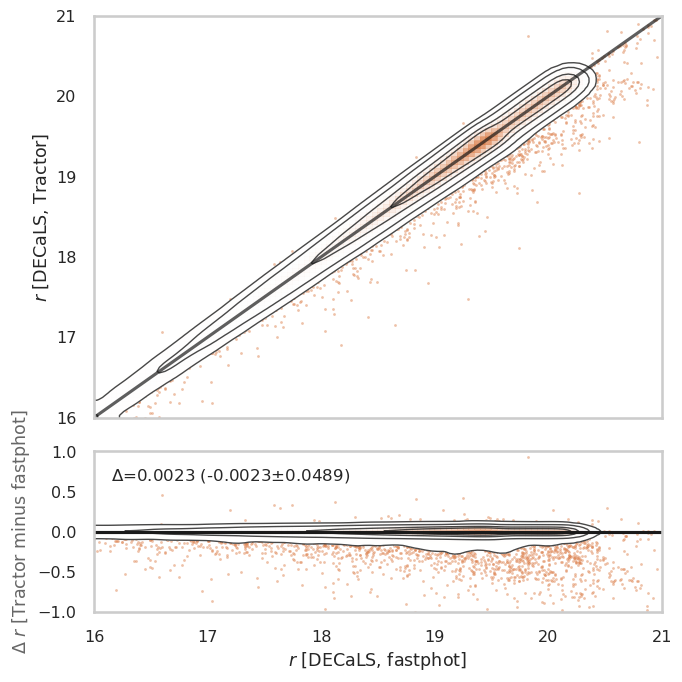

In [24]:
cplot(fastnorth['FLUX_SYNTH_PHOTMODEL_R'], metanorth['FLUX_R'], rlim, residlim2, 
      r'$r$ [DECaLS, fastphot]', r'$r$ [DECaLS, Tractor]', r'$\Delta\ r$ [Tractor minus fastphot]', isflux=True)

#### Compare $M_{0.1r}$ [BASS] vs $M_{0.1r}$ [DECaLS] and $M_{0.1g}$ [BASS] vs $M_{0.1g}$ [DECaLS].

Findings: 
* $M_{0.1g}$ [BASS] and $M_{0.1g}$ [DECaLS] agree to within $0.01$ mag.
* $M_{0.1r}$ [BASS] is approximately 0.016 mag fainter than $M_{0.1r}$ [DECaLS].

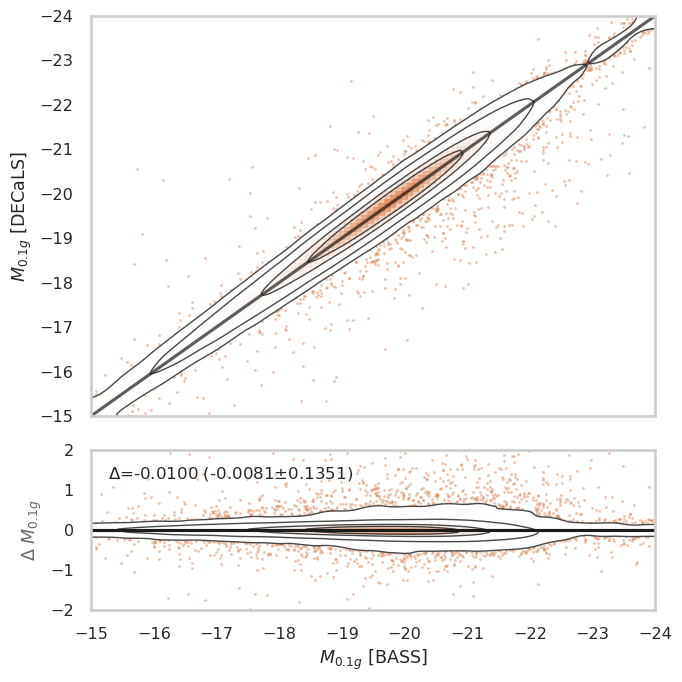

In [25]:
cplot(fastnorth['ABSMAG01_SDSS_G'], fastsouth['ABSMAG01_SDSS_G'], gabslim, residlim, 
      r'$M_{0.1g}$ [BASS]', r'$M_{0.1g}$ [DECaLS]', r'$\Delta\ M_{0.1g}$', isflux=False)

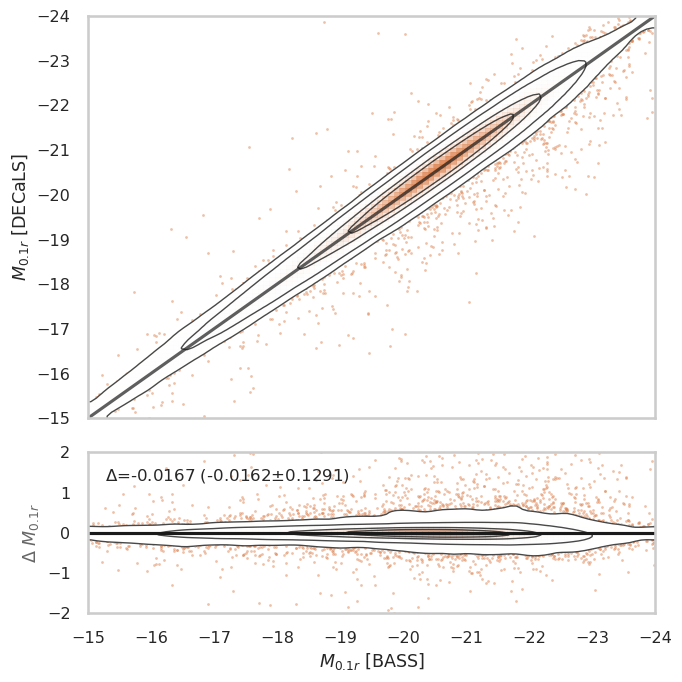

In [26]:
cplot(fastnorth['ABSMAG01_SDSS_R'], fastsouth['ABSMAG01_SDSS_R'], rabslim, residlim, 
      r'$M_{0.1r}$ [BASS]', r'$M_{0.1r}$ [DECaLS]', r'$\Delta\ M_{0.1r}$', isflux=False)

#### Compare the raw-counts $M_{0.1r}$ [BASS] vs $M_{0.1r}$ [DECaLS] and $M_{0.1g}$ [BASS] vs $M_{0.1g}$ [DECaLS] luminosity functions.

Findings: 
* There appears to be very good agreement. In particular, we do not appear to see the level of discrepancy we saw in the `iron/main` VAC (based on `fastspec`) at $-23\gtrsim M_{0.1g} \gtrsim -26$ and $-24\gtrsim M_{0.1r} \gtrsim -26$.

In [27]:
abslim = [-12, -28]
grlim = [0., 1.2]

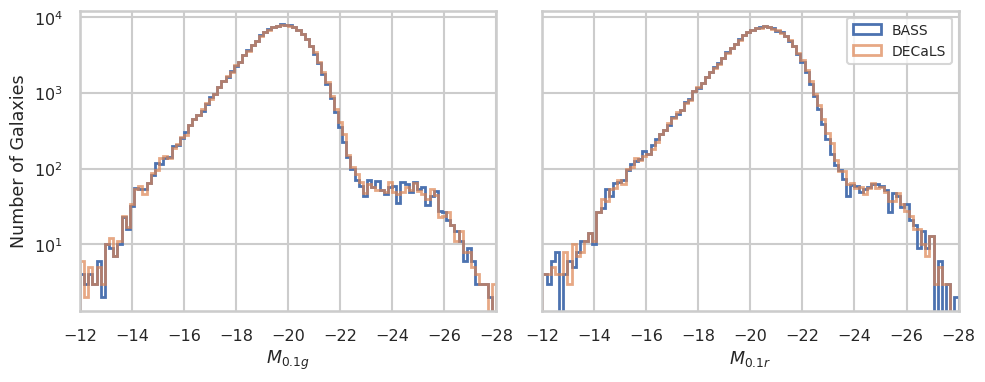

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
_ = ax1.hist(fastnorth['ABSMAG01_SDSS_G'], bins=100, log=True, 
             histtype='step', range=abslim[::-1], label='BASS', lw=2)
_ = ax1.hist(fastsouth['ABSMAG01_SDSS_G'], bins=100, log=True, 
             histtype='step', range=abslim[::-1], label='DECaLS', lw=2, alpha=0.7)
ax1.set_xlim(abslim)
ax1.set_xlabel(r'$M_{0.1g}$')
ax1.set_ylabel('Number of Galaxies')

_ = ax2.hist(fastnorth['ABSMAG01_SDSS_R'], bins=100, log=True, 
             histtype='step', range=abslim[::-1], label='BASS', lw=2)
_ = ax2.hist(fastsouth['ABSMAG01_SDSS_R'], bins=100, log=True, 
             histtype='step', range=abslim[::-1], label='DECaLS', lw=2, alpha=0.7)
ax2.set_xlim(abslim)
ax2.set_xlabel(r'$M_{0.1r}$')
ax2.legend(loc='upper right', fontsize=10)

fig.tight_layout()

Looking at the rest-frame color distribution, one could argue that the discrepancy is still at the $\approx0.01$ mag level.

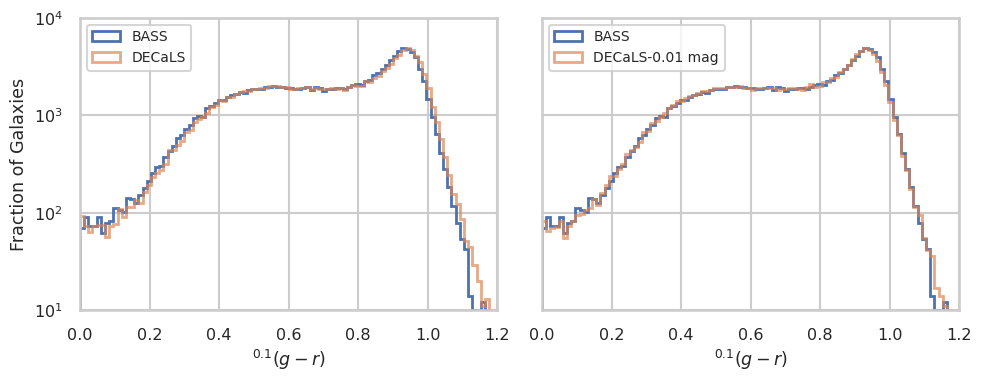

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

_ = ax1.hist(fastnorth['ABSMAG01_SDSS_G']-fastnorth['ABSMAG01_SDSS_R'], 
             bins=100, log=True, histtype='step', range=grlim,
             label='BASS', lw=2)
_ = ax1.hist(fastsouth['ABSMAG01_SDSS_G']-fastsouth['ABSMAG01_SDSS_R'], 
             bins=100, log=True, histtype='step', range=grlim,
             label='DECaLS', lw=2, alpha=0.7)
ax1.set_ylabel('Fraction of Galaxies')
ax1.legend(loc='upper left', fontsize=10)

_ = ax2.hist(fastnorth['ABSMAG01_SDSS_G']-fastnorth['ABSMAG01_SDSS_R'], 
             bins=100, log=True, histtype='step', range=grlim,
             label='BASS', lw=2)
_ = ax2.hist(fastsouth['ABSMAG01_SDSS_G']-fastsouth['ABSMAG01_SDSS_R']-0.01, 
             bins=100, log=True, histtype='step', range=grlim,
             label='DECaLS-0.01 mag', lw=2, alpha=0.7)
ax2.legend(loc='upper left', fontsize=10)

for xx in (ax1, ax2):
    xx.set_xlim(grlim)
    xx.set_ylim(10., 1e4)
    xx.set_xlabel(r'$^{0.1}(g-r)$')
    
fig.tight_layout()

#### So what is going on??

So at least one source of discrepancy must be due to the `fastphot` vs `fastspec` rest-frame photometry. Recall that both methods use the same (input) DESI redshift, but `fastphot` fits the broadband photometry only while `fastspec` fits the photometry *and* spectrophotometry jointly (simultaneously), after applying a simple aperture correction (which may not be negligible for bright BGS targets).

Indeed, ignoring color gradients in the aperture correction is likely introducing systematic biases at the level that we are observing.

In [30]:
I = (vacfast['ABSMAG01_IVAR_SDSS_G'] > 0) * (vacfast['ABSMAG01_IVAR_SDSS_R'] > 0)
N = I * (vacmeta['PHOTSYS'] == 'N')
S = I * (vacmeta['PHOTSYS'] == 'S')

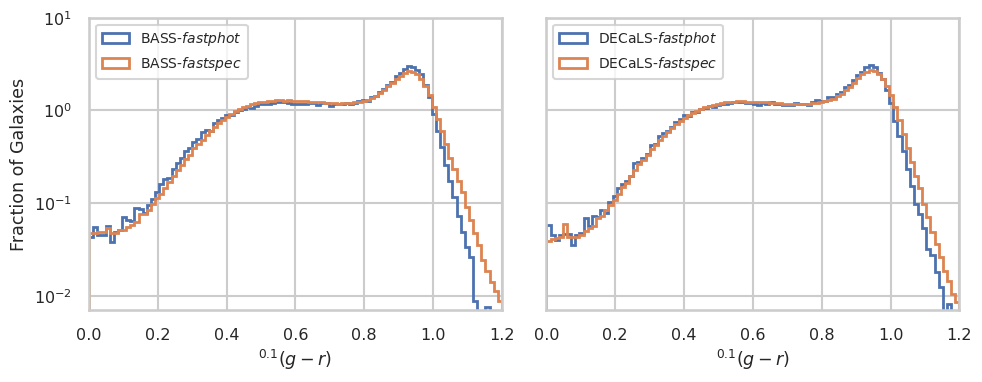

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

_ = ax1.hist(fastnorth['ABSMAG01_SDSS_G']-fastnorth['ABSMAG01_SDSS_R'], 
             bins=100, log=True, histtype='step', range=grlim,
             density=True, label='BASS-$fastphot$', lw=2)
_ = ax1.hist(vacfast['ABSMAG01_SDSS_G'][N]-vacfast['ABSMAG01_SDSS_R'][N], 
             bins=100, log=True, histtype='step', range=grlim,
             density=True, label='BASS-$fastspec$', lw=2)
ax1.set_ylabel('Fraction of Galaxies')
ax1.legend(loc='upper left', fontsize=10)

_ = ax2.hist(fastsouth['ABSMAG01_SDSS_G']-fastsouth['ABSMAG01_SDSS_R'], 
             bins=100, log=True, histtype='step', range=grlim,
             density=True, label='DECaLS-$fastphot$', lw=2)
_ = ax2.hist(vacfast['ABSMAG01_SDSS_G'][S]-vacfast['ABSMAG01_SDSS_R'][S], 
             bins=100, log=True, histtype='step', range=grlim,
             density=True, label='DECaLS-$fastspec$', lw=2)
ax2.legend(loc='upper left', fontsize=10)

for xx in (ax1, ax2):
    xx.set_xlim(grlim)
    xx.set_ylim(7e-3, 10.)
    xx.set_xlabel(r'$^{0.1}(g-r)$')
    
fig.tight_layout()